
Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [0]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from tqdm import tqdm
from torchvision import datasets, transforms
from torchsummary import summary

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [2]:
SEED = 1

cuda = torch.cuda.is_available()

# For reproducibility of results
torch.manual_seed(SEED)
if cuda:
    torch.cuda.manual_seed(SEED)

transform = transforms.Compose([
    # convert the data to torch.FloatTensor with values within the range [0.0 ,1.0]
    transforms.ToTensor(),

    # normalize the data with mean and standard deviation to keep values in range [-1, 1]
    # since there are 3 channels for each image,
    # we have to specify mean and std for each channel
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 64
dataloader_args = dict(
    shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True
) if cuda else dict(shuffle=True, batch_size=batch_size, num_workers=2)

trainset = datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(trainset, **dataloader_args)

testset = datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(testset, **dataloader_args)

classes = (
    'plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
)

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



plane   dog  deer  deer


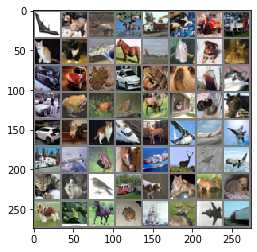

In [3]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [0]:
class Net(nn.Module):
    def __init__(self):
        """ This function instantiates all the model layers """
        super(Net, self).__init__()

        dropout_rate = 0.1

        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_rate),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_rate)
        )  # Input: 28x28x1 | Output: 26x26x8 | RF: 3x3

        self.transblock1 = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_rate)
        )

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_rate),

            # Depthwise separable convolution
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, groups=32, padding=1),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_rate)
        )  # Input: 28x28x1 | Output: 26x26x8 | RF: 3x3

        self.transblock2 = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_rate)
        )  # Input: 26x26x8 | Output: 24x24x8 | RF: 5x5

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, dilation=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_rate),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_rate)
        )  # Input: 24x24x8 | Output: 22x22x16 | RF: 7x7

        self.transblock3 = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_rate)
        )  # Input: 22x22x16 | Output: 20x20x16 | RF: 9x9

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_rate),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_rate)
        )

        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool2d(1)
        )  # Input: 6x6x10 | Output: 1x1x10 | RF: 28x28

        self.fc = nn.Sequential(
            nn.Linear(64, 10)
        )
    
    def forward(self, x):
        """ This function defines the network structure """
        x = self.convblock1(x)
        x = self.transblock1(x)
        x = self.convblock2(x)
        x = self.transblock2(x)
        x = self.convblock3(x)
        x = self.transblock3(x)
        x = self.convblock4(x)
        x = self.gap(x)
        x = x.view(-1, 64)
        x = self.fc(x)
        return x

In [9]:
device = torch.device("cuda" if cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,496
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
           Dropout-8           [-1, 64, 32, 32]               0
         MaxPool2d-9           [-1, 64, 16, 16]               0
           Conv2d-10           [-1, 32, 16, 16]           2,080
             ReLU-11           [-1, 32, 16, 16]               0
      BatchNorm2d-12           [-1, 32, 16, 16]              64
          Dropout-13           [-1, 32, 16, 16]               0
           Conv2d-14           [-1, 32,

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [0]:
def train(model, train_loader, device, optimizer, criterion):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar, 0):
        # Get samples
        data, target = data.to(device), target.to(device)

        # Set gradients to zero before starting backpropagation
        optimizer.zero_grad()

        # Predict output
        y_pred = model(data)

        # Calculate loss
        loss = criterion(y_pred, target)

        # Perform backpropagation
        loss.backward()
        optimizer.step()

        # Update progress bar
        pred = y_pred.argmax(dim=1, keepdim=False)
        correct += pred.eq(target).sum().item()
        processed += len(data)
        pbar.set_description(desc=f'Loss={loss.item():0.2f} Batch ID={batch_idx} Accuracy={(100 * correct / processed):.2f}')

In [0]:
def val(model, val_loader, device, criterion):
    model.eval()
    correct = 0
    val_loss = 0
    with torch.no_grad():
        for data, target in val_loader:
            img_batch = data  # This is done to keep data in CPU
            data, target = data.to(device), target.to(device)  # Get samples
            output = model(data)  # Get trained model output
            val_loss += criterion(output, target).item()  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=False)  # Get the index of the max log-probability

            correct += pred.eq(target).sum().item()
    
    val_loss /= len(val_loader.dataset)
    accuracy = 100. * correct / len(val_loader.dataset)
    print(f'\nValidation set: Average loss: {val_loss:.4f}, Accuracy: {correct}/{len(val_loader.dataset)} ({accuracy:.2f}%)\n')

In [12]:
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
epochs = 50

for epoch in range(1, epochs + 1):
    print(f'Epoch {epoch}:')
    train(model, trainloader, device, optimizer, criterion)
    val(model, testloader, device, criterion)

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0232, Accuracy: 4598/10000 (45.98%)

Epoch 2:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0197, Accuracy: 5489/10000 (54.89%)

Epoch 3:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0174, Accuracy: 5971/10000 (59.71%)

Epoch 4:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0165, Accuracy: 6274/10000 (62.74%)

Epoch 5:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0155, Accuracy: 6487/10000 (64.87%)

Epoch 6:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0141, Accuracy: 6830/10000 (68.30%)

Epoch 7:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0143, Accuracy: 6798/10000 (67.98%)

Epoch 8:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0139, Accuracy: 6883/10000 (68.83%)

Epoch 9:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0129, Accuracy: 7124/10000 (71.24%)

Epoch 10:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0118, Accuracy: 7317/10000 (73.17%)

Epoch 11:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0123, Accuracy: 7310/10000 (73.10%)

Epoch 12:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0114, Accuracy: 7480/10000 (74.80%)

Epoch 13:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0115, Accuracy: 7461/10000 (74.61%)

Epoch 14:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0109, Accuracy: 7611/10000 (76.11%)

Epoch 15:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0104, Accuracy: 7685/10000 (76.85%)

Epoch 16:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0103, Accuracy: 7682/10000 (76.82%)

Epoch 17:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0105, Accuracy: 7686/10000 (76.86%)

Epoch 18:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0105, Accuracy: 7687/10000 (76.87%)

Epoch 19:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0103, Accuracy: 7729/10000 (77.29%)

Epoch 20:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0105, Accuracy: 7709/10000 (77.09%)

Epoch 21:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0099, Accuracy: 7855/10000 (78.55%)

Epoch 22:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0099, Accuracy: 7841/10000 (78.41%)

Epoch 23:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0094, Accuracy: 7961/10000 (79.61%)

Epoch 24:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0097, Accuracy: 7907/10000 (79.07%)

Epoch 25:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0095, Accuracy: 7924/10000 (79.24%)

Epoch 26:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0099, Accuracy: 7844/10000 (78.44%)

Epoch 27:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0095, Accuracy: 7969/10000 (79.69%)

Epoch 28:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0090, Accuracy: 7997/10000 (79.97%)

Epoch 29:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0097, Accuracy: 7924/10000 (79.24%)

Epoch 30:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0093, Accuracy: 7989/10000 (79.89%)

Epoch 31:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0089, Accuracy: 8039/10000 (80.39%)

Epoch 32:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0093, Accuracy: 7995/10000 (79.95%)

Epoch 33:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0089, Accuracy: 8089/10000 (80.89%)

Epoch 34:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0089, Accuracy: 8076/10000 (80.76%)

Epoch 35:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0086, Accuracy: 8184/10000 (81.84%)

Epoch 36:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0088, Accuracy: 8080/10000 (80.80%)

Epoch 37:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0088, Accuracy: 8125/10000 (81.25%)

Epoch 38:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0084, Accuracy: 8186/10000 (81.86%)

Epoch 39:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0087, Accuracy: 8143/10000 (81.43%)

Epoch 40:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0088, Accuracy: 8126/10000 (81.26%)

Epoch 41:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0087, Accuracy: 8174/10000 (81.74%)

Epoch 42:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0087, Accuracy: 8141/10000 (81.41%)

Epoch 43:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0085, Accuracy: 8206/10000 (82.06%)

Epoch 44:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0087, Accuracy: 8192/10000 (81.92%)

Epoch 45:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0085, Accuracy: 8184/10000 (81.84%)

Epoch 46:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0085, Accuracy: 8193/10000 (81.93%)

Epoch 47:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0082, Accuracy: 8258/10000 (82.58%)

Epoch 48:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0085, Accuracy: 8212/10000 (82.12%)

Epoch 49:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0085, Accuracy: 8213/10000 (82.13%)

Epoch 50:


Loss=0.35 Batch ID=781 Accuracy=85.47: 100%|██████████| 782/782 [00:16<00:00, 48.76it/s]



Validation set: Average loss: 0.0084, Accuracy: 8207/10000 (82.07%)



5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



GroundTruth:   frog  deer   dog  bird


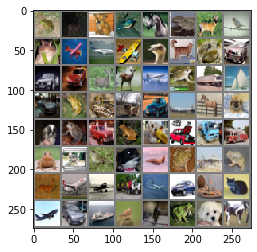

In [10]:
dataiter = iter(testloader)
images, labels = dataiter.next()

images_cuda, labels_cuda = images.to(device), labels.to(device)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [0]:
outputs = model(images_cuda)

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [12]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   frog   cat   dog  frog


That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [13]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 86 %
Accuracy of   car : 89 %
Accuracy of  bird : 74 %
Accuracy of   cat : 65 %
Accuracy of  deer : 86 %
Accuracy of   dog : 74 %
Accuracy of  frog : 96 %
Accuracy of horse : 82 %
Accuracy of  ship : 85 %
Accuracy of truck : 91 %
